In [1]:
# The following repositories were used for reference in writing this code
# https://github.com/MishaLaskin/vqvae
# https://github.com/ritheshkumar95/pytorch-vqvae
# https://github.com/AntixK/PyTorch-VAE, Apache-2.0 License
# https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py, Apache-2.0 License
# The original template code provided from the DL&RL module was used as structure
# make sure you reference any code you have studied as above here

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch import autograd
import os

batch_size  = 64
dataset = 'cifar10'
image_size = 32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    image_size = 32
    cifar = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
            ]))
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    allowed_classes = [2, 7]
    targets = torch.tensor(cifar.targets)
    for i, c in enumerate(class_names):
      if i not in allowed_classes:
        targets[targets == i] = -1
    for i, c in enumerate(allowed_classes):
      targets[targets == c] = i
    """
    birds = torch.nonzero(targets == 2)
    horses = torch.nonzero(targets == 7)
    """
    cifar.targets = targets.tolist()
    target_idx = torch.nonzero(targets != -1)
    cifar = torch.utils.data.Subset(cifar, target_idx)
    train_loader = torch.utils.data.DataLoader(cifar, shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    image_size = 96
    stl = torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ]))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10
    allowed_classes = [1, 6]
    targets = torch.tensor(stl.labels)
    for i, c in enumerate(class_names):
      if i not in allowed_classes:
        targets[targets == i] = -1
    for i, c in enumerate(allowed_classes):
      targets[targets == c] = i
    stl.labels = targets.tolist()
    target_idx = torch.nonzero(targets != -1)
    stl = torch.utils.data.Subset(stl, target_idx)
    train_loader = torch.utils.data.DataLoader(stl, shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))

Files already downloaded and verified


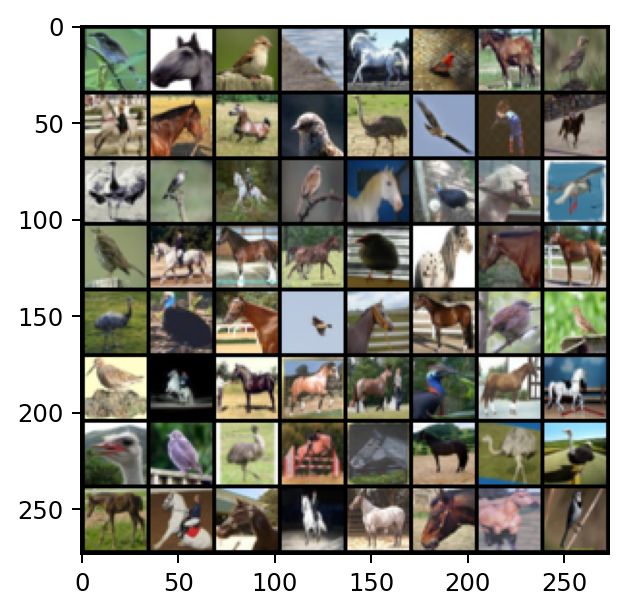

In [4]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a Vector Quantized Variational Autoencoder (VQ-VAE)**

In [5]:
torch.autograd.set_detect_anomaly(True)
class VQEncoderBlock(nn.Module):
  def __init__(self, in_size, out_size, kernel_size = 4, stride = 2, padding = 1):
    super(VQEncoderBlock, self).__init__()
    self.convolutional_block = nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size = kernel_size, stride = stride, padding = padding),
        nn.BatchNorm2d(out_size),
        nn.LeakyReLU(inplace = True)
    )

  def forward(self, x):
    return self.convolutional_block(x)

class VQDecoderBlock(nn.Module):
  def __init__(self, in_size, out_size, kernel_size = 4, stride = 2, padding = 1):
    super(VQDecoderBlock, self).__init__()
    self.convolutional_block = nn.Sequential(
        nn.ConvTranspose2d(in_size, out_size, kernel_size = kernel_size, stride = stride, padding = padding),
        nn.BatchNorm2d(out_size),
        nn.LeakyReLU(inplace=True)
    )

  def forward(self, x):
    return self.convolutional_block(x)

class VQResidualBlock(nn.Module):
  def __init__(self, in_size, out_size, hidden_size):
    super(VQResidualBlock, self).__init__()
    self.residual = nn.Sequential(
        nn.ReLU(inplace = True),
        nn.Conv2d(in_size, hidden_size, kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.ReLU(inplace = True),
        nn.Conv2d(hidden_size, out_size, kernel_size = 1, stride = 1, bias = False)
    )

  def forward(self, x):
      x = x + self.residual(x)
      return x

class VQEncoder(nn.Module):
  def __init__(self, image_depth: int, residual_layers: int, hidden_dims: list, residual_hidden_size = 32):
    super(VQEncoder, self).__init__()

    encoder_blocks = [
                      VQEncoderBlock(image_depth, hidden_dims[0])
    ]
    for i in range(len(hidden_dims) - 1):
      encoder_blocks += [
                         VQEncoderBlock(hidden_dims[i], hidden_dims[i + 1])
      ]
    encoder_blocks += [
                       nn.Conv2d(hidden_dims[-1], hidden_dims[-1], kernel_size = 3, stride = 1, padding = 1)
    ]
    residual_blocks = []
    for i in range(residual_layers):
      residual_blocks += [
                     VQResidualBlock(hidden_dims[-1], hidden_dims[-1], residual_hidden_size)     
      ]
    self.encoder = nn.Sequential(*encoder_blocks)
    self.residual = nn.Sequential(*residual_blocks)
    self.relu = nn.LeakyReLU(inplace = True)
  
  def forward(self, x):
    z = self.encoder(x)
    for layer in self.residual:
      z = layer(z)
    z = self.relu(z)
    return z

class VQDecoder(nn.Module):
  def __init__(self, image_depth: int, residual_layers: int, hidden_dims: list, embedding_dim: int, residual_hidden_size = 32):
    super(VQDecoder, self).__init__()

    decoder_blocks = [
                      nn.ConvTranspose2d(embedding_dim, hidden_dims[-1], kernel_size = 3, stride = 1, padding = 1),
    ]
    for i in range(residual_layers):
      decoder_blocks += [
                     VQResidualBlock(hidden_dims[-1], hidden_dims[-1], residual_hidden_size)     
      ]
    decoder_blocks += [
                       nn.LeakyReLU(inplace = True)
    ]
    for i in range(len(hidden_dims) - 1, 0, -1):
      decoder_blocks += [
                         VQDecoderBlock(hidden_dims[i], hidden_dims[i - 1])
      ]
    #I've found that Sigmoid works best here, if for no other reason than the outputs are scaled in a suitable range for imshow and don't get clipped
    decoder_blocks += [
                  nn.ConvTranspose2d(hidden_dims[0], image_depth, kernel_size = 4, stride = 2, padding = 1),
                  nn.Sigmoid()
    ]
    self.decoder = nn.Sequential(*decoder_blocks)
  
  def forward(self, x):
    return self.decoder(x)

class VectorQuantizer(nn.Module):
  """
  Beta is the commitment cost
  """
  def __init__(self,  num_embeddings: int, embedding_dim: int, beta: float):
    super(VectorQuantizer, self).__init__()
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim
    self.beta = beta
    self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
    self.embedding.weight.data.uniform_(-1.0 / self.num_embeddings, 1.0 / self.num_embeddings)

  """
  See
  https://github.com/MishaLaskin/vqvae/blob/master/models/quantizer.py
  and
  https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
  for where this implementation for generating the quantized vector was adapted from.
  This is the non-exponential moving average version even though EMA is apparently better.
  My understanding of how it works was too shaky to implement it myself
  """
  def forward(self, x):
    z = x.permute(0, 2, 3, 1).contiguous()
    z_flat = z.view(-1, self.embedding_dim)

    #This is the L2 distance between the latent values and the embdedding weights 
    l2_dist = torch.sum(z_flat ** 2, dim = 1, keepdim = True) + torch.sum(self.embedding.weight ** 2, dim = 1) - 2 * torch.matmul(z_flat, self.embedding.weight.t())

    #This gets the closest encodings and one-hot encodes them
    encoding_indices = torch.argmin(l2_dist, dim = 1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device = device)
    encodings.scatter_(1, encoding_indices, 1)

    #Calculate the quantized latent vectors using the closest encodings and the weights from the embedding layer
    quantized = torch.matmul(encodings, self.embedding.weight).view(z.shape)
    
    #MSE loss for the embeddings
    commitment_loss = F.mse_loss(quantized.detach(), z)
    embedding_loss = F.mse_loss(quantized, z.detach())
    vq_loss = commitment_loss * self.beta + embedding_loss

    quantized = z + (quantized - z).detach()

    avg = torch.mean(encodings, dim = 0)
    perplexity = torch.exp(-torch.sum(avg * torch.log(avg + 1e-10)))
    quantized = quantized.permute(0, 3, 1, 2).contiguous()
    return {
        'loss': vq_loss,
        'quantized': quantized,
        'perplexity': perplexity,
        'distances': l2_dist,
        'encodings': encodings,
        'encoding_indices': encoding_indices.view(*z.shape[:3]).unsqueeze(dim=1)
    }

"""
The Gated PixelCNN implementation is heavily based on:
https://github.com/MishaLaskin/vqvae/blob/master/pixelcnn/models.py
"""
class PXGateBlock(nn.Module):
  def __init__(self):
    super(PXGateBlock, self).__init__()

  def forward(self, x):
    #Split the tensor into 2 chunks so that some will be passed to tanh and some to the sigmoid
    x, y = x.chunk(2, dim = 1)
    return torch.tanh(x) * torch.sigmoid(y)

"""
The PixelCNN works better with uniform distribution starting values but we need to make sure we only 
apply these in blocks that have convolutional components
"""
def init_weights_and_biases(model_component):
  if type(model_component) != nn.Conv2d and type(model_component) != PXGatedMaskedBlock and type(model_component) != PXGatedMaskABlock and type(model_component) != PXGatedMaskBBlock:
    return
  try:
    nn.init.xavier_uniform_(model_component.weight.data)
    model_component.bias.data.fill_(0)
  except AttributeError:
    pass

class PXGatedMaskedBlock(nn.Module):
  def __init__(self, vq_embedding_dim = 64, kernel = 3, use_residual = True, num_classes = 2):
    super(PXGatedMaskedBlock, self).__init__()
    self.use_residual = use_residual

    self.condition_embedding = nn.Embedding(num_classes, 2 * vq_embedding_dim)

    #The convolutions are split amongst 2 stacks: horizontal and vertical. This removes the blind spots
    #See Conditional Image generation with PixelCNN decoders by Van der Oord et al (https://arxiv.org/pdf/1606.05328.pdf)
    #The horizontal stack conditions on rows below
    kernel_tuple = (1, kernel // 2 + 1)
    padding_tuple = (0, kernel // 2)
    self.horizontal_stack = nn.Conv2d(vq_embedding_dim, vq_embedding_dim * 2, kernel_tuple, 1, padding_tuple)
    self.horizontal_residual = nn.Conv2d(vq_embedding_dim, vq_embedding_dim, 1)

    #The vertical stack conditions on rows above.
    kernel_tuple = (kernel // 2 + 1, kernel)
    padding_tuple = (kernel // 2, kernel // 2)
    self.vertical_stack = nn.Conv2d(vq_embedding_dim, vq_embedding_dim * 2, kernel_tuple, 1, padding_tuple)
    self.v_to_h = nn.Conv2d(vq_embedding_dim * 2, vq_embedding_dim * 2, 1)

    self.gate = PXGateBlock()

  def forward(self, x_horizontal, x_vertical, condition):
    #This is how we make the PixelCNN conditional which allows us to train on the class as well as the latents from the VAE then generate items of said class
    embedded_condition = self.condition_embedding(condition)

    #The purpose of masking is to ensure that the PixelCNN doesn't "use" data from future pixels i.e. things it hasn't seen yet. Only condition on history
    horizontal = self.horizontal_stack(x_horizontal)
    horizontal = horizontal[:, :, :, :x_horizontal.size(-2)]
    
    vertical = self.vertical_stack(x_vertical)
    vertical = vertical[:, :, :x_vertical.size(-1), :]
    
    vertical_result = self.gate(vertical + embedded_condition[:, :, None, None])
    v_to_h = self.v_to_h(vertical)

    out = self.gate(v_to_h + horizontal + embedded_condition[:, :, None, None])
    #The use of the residuals speeds up learning (an alternative to ResNet blocks). The original Gated PixelCNN authors found that residuals for vertical
    #dimensions had little effect https://arxiv.org/pdf/1606.05328.pdf
    if self.use_residual:
        horizontal_result = self.horizontal_residual(out) + x_horizontal
    else:
        horizontal_result = self.horizontal_residual(out)

    return horizontal_result, vertical_result

class PXGatedMaskABlock(nn.Module):
  def __init__(self, vq_embedding_dim = 64, kernel = 3, use_residual = True, num_classes = 2):
    super(PXGatedMaskABlock, self).__init__()

    self.block = PXGatedMaskedBlock(vq_embedding_dim, kernel, use_residual, num_classes)

  def forward(self, x_horizontal, x_vertical, condition):
    self.block.horizontal_stack.weight.data[:, :, :, -1].zero_()
    self.block.vertical_stack.weight.data[:, :, -1].zero_()
    return self.block.forward(x_horizontal, x_vertical, condition)
  
"""
Basically an alias
"""
class PXGatedMaskBBlock(nn.Module):
  def __init__(self, vq_embedding_dim = 64, kernel = 3, use_residual = True, num_classes = 2):
    super(PXGatedMaskBBlock, self).__init__()

    self.block = PXGatedMaskedBlock(vq_embedding_dim, kernel, use_residual, num_classes)

  def forward(self, x_horizontal, x_vertical, condition):
    return self.block.forward(x_horizontal, x_vertical, condition)

class PixelCNN(nn.Module):
  """
  The number of embeddings and the dimension of embeddings must match the VQVAE settings.
  For the vq_embedding_dim of 64, the VQVAE latent output is technically an 8x8x1 image hence the matching
  """
  def __init__(self, num_embeddings = 512, vq_embedding_dim = 64, num_layers = 15, num_classes = 2):
    super(PixelCNN, self).__init__()
    self.vq_embedding_dim = vq_embedding_dim
    #Need to save this for the loss function later
    self.num_embeddings = num_embeddings
    self.num_classes = num_classes
    self.embedding_layer = nn.Embedding(num_embeddings, vq_embedding_dim)

    pixel_layers = [
                    PXGatedMaskABlock(vq_embedding_dim, 7, False, num_classes)
    ]

    for i in range(num_layers - 1):
      pixel_layers += [
              PXGatedMaskBBlock(vq_embedding_dim, 3, True, num_classes)         
      ]
    
    self.pixel_layers = nn.Sequential(*pixel_layers)
    #Don't use an activation function here because we need to pass this output into the VQVAE decoder
    self.final_layer = nn.Sequential(
            nn.Conv2d(vq_embedding_dim, 512, 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, num_embeddings, 1)
    )
    self.apply(init_weights_and_biases)
    self.optimiser = torch.optim.AdamW(self.parameters(), lr = 1e-3, weight_decay = 1e-2)
    self.train_epoch = 0
    self.best = {'loss': None, 'state_dict': None, 'optimiser': None, 'epoch': None}

  def forward(self, x, y):
    embedding = self.embedding_layer(x.view(-1)).view(x.shape + (-1,))
    z = embedding.permute(0, 3, 1, 2)
    x_horizontal = z
    x_vertical = z
    for layer in self.pixel_layers:
        x_horizontal, x_vertical = layer(x_horizontal, x_vertical, y)

    z = self.final_layer(x_horizontal)
    return z

  def loss_function(self, y, x):
    forward = y.permute(0, 2, 3, 1).contiguous()
    return F.cross_entropy(forward.view(-1, self.num_embeddings), x.view(-1))

  def sample_forward(self, x, y, i, j):
    return F.softmax(self.forward(x, y)[:, :, i, j], -1)

  def sample(self, n, category, embedded_size = 8):
    label = torch.empty(n).fill_(category).contiguous()
    label = label.long().to(device)
    sample_in = torch.zeros((n, embedded_size, embedded_size), dtype=torch.int64, device=device)
    for i in range(embedded_size):
      for j in range(embedded_size):
          sample_in.data[:, i, j].copy_(self.sample_forward(sample_in, label, i, j).multinomial(1).squeeze().data)
    return sample_in

  def load_saved(self, params):
    self.load_state_dict(params['PRIOR_MODEL'])
    self.optimiser.load_state_dict(params['optimiser'])
    self.train_epoch = params['epoch']

  def save(self):
    torch.save({'PRIOR_MODEL':self.state_dict(), 'optimiser':self.optimiser.state_dict(), 'epoch':self.train_epoch}, 'drive/My Drive/training/' + dataset + '_save_vqvae_pixelcnn.chkpt')
    if self.best['loss'] is not None:
      torch.save({'PRIOR_MODEL':self.best['state_dict'], 'optimiser':self.best['optimiser'], 'epoch':self.best['epoch']}, 'drive/My Drive/training/' + dataset + '_save_vqvae_pixelcnn_best.chkpt')

  def train(self, epochs, trained_vqvae_model, epoch_callback = None, label_change_chance = 0.075):
    while (self.train_epoch < epochs):
      # array(s) for the performance measures
      loss_arr = np.zeros(0)
      # iterate over some of the train dataset
      for i, data in enumerate(train_loader, 0):
          x, y = data
          with torch.no_grad():
            x = x.to(device)
            _, _, _, _, encoded_indices = trained_vqvae_model.forward(x)
            encoded_indices = encoded_indices.detach()

          x, y = encoded_indices.to(device).squeeze(dim = 1), y.to(device)
          y = torch.where(torch.randint(0, 1000, (batch_size, )).to(device) > int(label_change_chance * 1000), y, (torch.ones(batch_size) * (self.num_classes - 1)).to(device).long())
          #print('X', x.shape)
          horizontal_repr = self.forward(x, y)
          #print('recon', recon_x.shape)
          #print('X', x.shape)
          #print('input', input.shape)
          loss = self.loss_function(horizontal_repr, x)
          #if torch.isnan(loss):
            #print('Loss NaN')
          self.optimiser.zero_grad()
          loss.backward()
          self.optimiser.step()

          # collect stats
          loss_arr = np.append(loss_arr, loss.item())
      if self.best['loss'] is None or loss_arr.mean().item() < self.best['loss']:
        self.best = {
            'loss': loss_arr.mean().item(),
            'state_dict': self.state_dict(),
            'optimiser': self.optimiser.state_dict(),
            'epoch': self.train_epoch
        }
      if epoch_callback is not None:
        epoch_callback(self, self.train_epoch, loss_arr)
      self.train_epoch += 1

class VQVAE(nn.Module):
  def __init__(self, image_depth: int, hidden_dims: list, residual_layers = 6, residual_hidden_size = 32, num_embeddings = 512, embedding_dim = 64, beta = 0.25):
    super(VQVAE, self).__init__()
    self.hidden_dims = hidden_dims
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim
    self.encoder = VQEncoder(image_depth, residual_layers, hidden_dims, residual_hidden_size)
    self.pre_embed = nn.Sequential(
                nn.Conv2d(hidden_dims[-1], embedding_dim, kernel_size = 1, stride = 1),
                nn.LeakyReLU(inplace = True)
    )
    self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, beta)
    self.decoder = VQDecoder(image_depth, residual_layers, hidden_dims, embedding_dim, residual_hidden_size)
    self.optimiser = torch.optim.AdamW(self.parameters(), lr = 1e-3, weight_decay = 1e-2)
    self.train_epoch = 0

  def forward(self, x):
    z = self.encoder(x)
    z = self.pre_embed(z)
    vq = self.vq_layer(z)
    loss = vq['loss']
    quantized = vq['quantized']
    perplexity = vq['perplexity']
    encoding_indices = vq['encoding_indices']
    decoded = self.decoder(quantized)
    return decoded, x, loss, perplexity, encoding_indices

  def loss_function(self, input_x, recon_x, vq_loss):
    recon_loss = F.mse_loss(recon_x, input_x)
    return recon_loss + vq_loss

  def generate_batch(self, x):
    x = x.to(device)
    return self.forward(x)[0]

  def lerp_priors(self, a0, a1, w):
    a0 = a0.float()
    a1 = a1.float()
    r = (1 - w) * a0 + w * a1;
    return r.long()

  def sample_priors(self, prior_samples):
    """
    Make sure the correct resultant from convolution is passed through
    """
    conv_res_size = prior_samples.shape[2]
    b_sz = prior_samples.shape[0]
    prior_samples = prior_samples.view(-1, 1)
    min_encodings = torch.zeros(prior_samples.size(0), self.num_embeddings).to(device)
    min_encodings.scatter_(1, prior_samples, 1)
    weights = self.vq_layer.embedding.weight
    z = torch.matmul(min_encodings, weights).view((b_sz, conv_res_size, conv_res_size, self.embedding_dim)) 
    z = z.permute(0, 3, 1, 2).contiguous()
 
    return self.decoder(z)

  def reconstruct(self, x):
    x = x.to(device)
    decoded, x, loss, perplexity, encoding_indices = self.forward(x)
    return self.sample_priors(encoding_indices)

  """
  Warning: calling this function without a trained prior model will return garbage results
  """
  def sample(self, n, category, prior_model):
    #Nasty way of figuring out the size of the image after convolutional layers. Should do this mathematically to save processing. Oh well
    x, _ = next(train_iterator)
    x = x.to(device)
    _, _, _, _, encoding_indices = self.forward(x)
    #Use the technique in https://arxiv.org/pdf/1711.00937.pdf of passing modelled priors from PixelCNN into decoder
    prior_samples = prior_model.sample(n, category, encoding_indices.shape[2])
    return self.sample_priors(prior_samples)
    

  def load_saved(self, params):
    self.load_state_dict(params['A'])
    self.optimiser.load_state_dict(params['optimiser'])
    self.train_epoch = params['epoch']

  def save(self):
    torch.save({'A':self.state_dict(), 'optimiser':self.optimiser.state_dict(), 'epoch':self.train_epoch}, 'drive/My Drive/training/' + dataset + '_save_vqvae.chkpt')

  def train(self, epochs = 100, epoch_callback = None):
    while (self.train_epoch < epochs):
      # array(s) for the performance measures
      loss_arr = np.zeros(0)
      # iterate over some of the train dateset
      for i, data in enumerate(train_loader, 0):

          # sample x from the dataset
          x, _ = data
          x = x.to(device)
          #print('X', x.shape)
          recon_x, input, vq_loss, perplexity, encoding_indices = self.forward(x)
          #print('recon', recon_x.shape)
          #print('X', x.shape)
          #print('input', input.shape)
          loss = self.loss_function(recon_x, x, vq_loss)
          #if torch.isnan(loss):
            #print('Loss NaN')
          self.optimiser.zero_grad()
          loss.backward()
          self.optimiser.step()

          # collect stats
          loss_arr = np.append(loss_arr, loss.item())

      if epoch_callback is not None:
        epoch_callback(self, self.train_epoch, loss)
      self.train_epoch += 1

**Main training loop**

In [6]:
def vqvae_train_callback(model, epoch, loss):
  x, _ = next(train_iterator)
  g = model.generate_batch(x)

  # plot some examples
  print('epoch '  + str(epoch) + ', loss ' + str(loss.mean()))
  plt.rcParams['figure.dpi'] = 100
  plt.grid(False)
  plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
  plt.show()
  plt.pause(0.0001)

def pixelcnn_train_callback(model, epoch, loss):
  print('pixelcnn epoch '  + str(epoch) + ', loss ' + str(loss.mean()))

#========= SET TRAINING OR TESTING MODE HERE =========
TRAIN_VAE = False
TRAIN_PIXEL = False
CONTINUE_TRAIN_PIXEL = True #Should we restore from the last checkpoint rather than the best score? Only applies in training mode for PixelCNN

A = VQVAE(3, [128, 256], 2).to(device)
print(f'> Number of vqv autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
if TRAIN_VAE:
  A.train(100, vqvae_train_callback)
  A.save()
else:
  try:
    params = torch.load('drive/My Drive/training/' + dataset + '_save_vqvae.chkpt')
    A.load_saved(params)
  except FileNotFoundError:
    print('VQVAE has not been trained yet for this dataset. Could not find model.')

PRIOR_MODEL = PixelCNN(512, 64, 15, 3).to(device)
print(f'> Number of pixelcnn prior parameters {len(torch.nn.utils.parameters_to_vector(PRIOR_MODEL.parameters()))}')
if TRAIN_PIXEL:
  if CONTINUE_TRAIN_PIXEL:
    try:
      params = torch.load('drive/My Drive/training/' + dataset + '_save_vqvae_pixelcnn.chkpt')
      PRIOR_MODEL.load_saved(params)
    except FileNotFoundError:
      print('PixelCNN has not been trained yet for this dataset. Could not find training checkpoint.')
  PRIOR_MODEL.train(200, A, pixelcnn_train_callback, 0.1)
  PRIOR_MODEL.save()
else:
  try:
    params = torch.load('drive/My Drive/training/' + dataset + '_save_vqvae_pixelcnn_best.chkpt')
    PRIOR_MODEL.load_saved(params)
  except FileNotFoundError:
    print('PixelCNN has not been trained yet for this dataset. Could not find best model.')

> Number of vqv autoencoder parameters 2177091
> Number of pixelcnn prior parameters 1828032


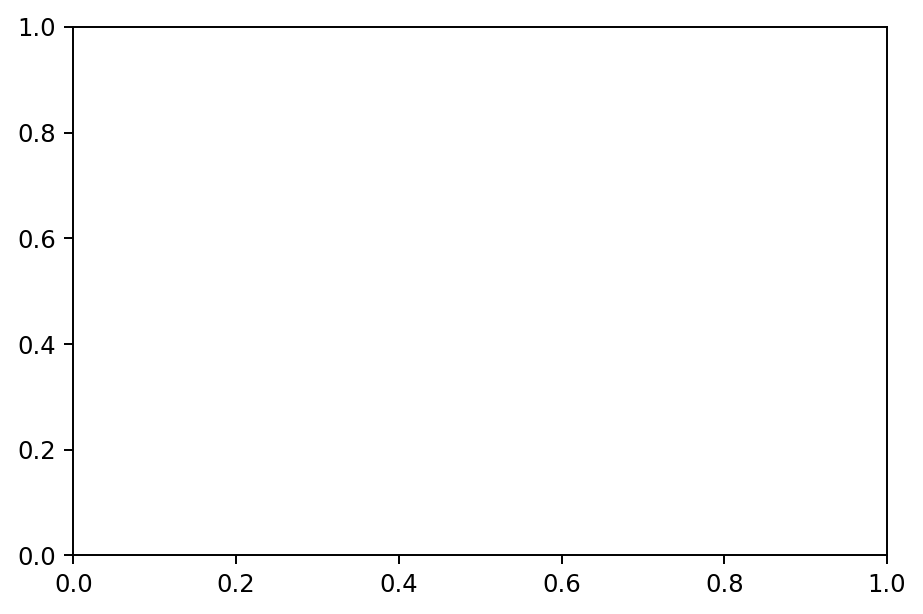

In [8]:
# now show your best batch of data for the submission, right click and save the image for your report
g = A.sample(64, 2, PRIOR_MODEL)
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

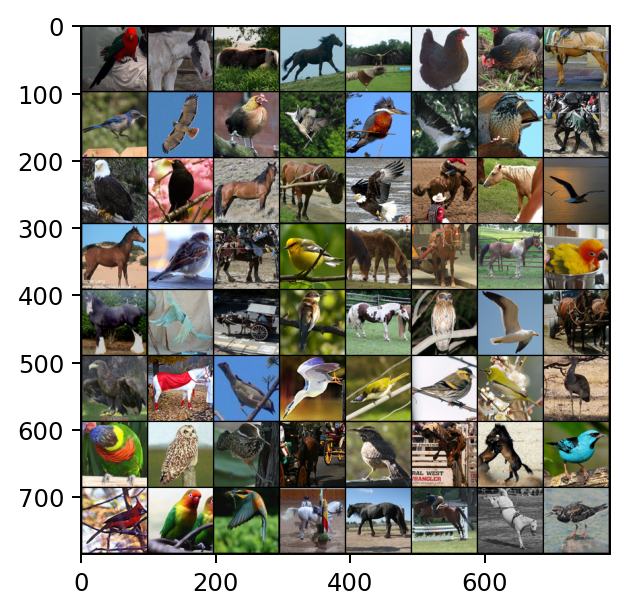

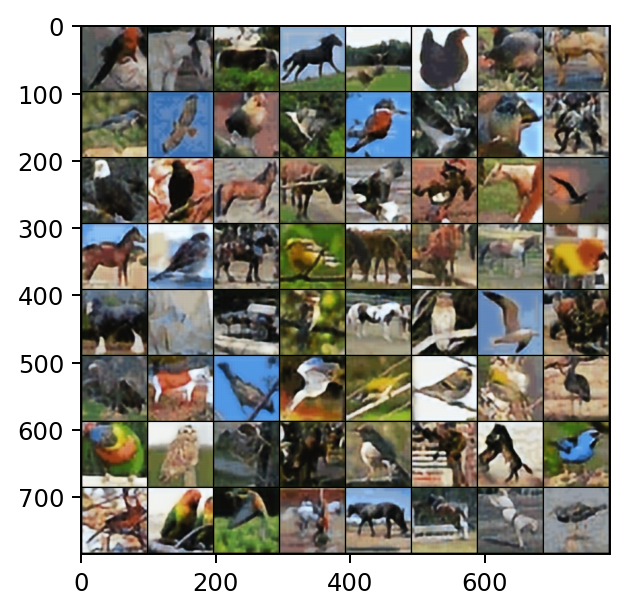

In [ ]:
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
test_x = A.reconstruct(x)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(test_x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
#Save cells just in case a model needs to be saved outside of the usual main components. Run these cells manually.
A.save()

In [ ]:
PRIOR_MODEL.save()